Plotting transformed images for class: Powdery mildew
Plotting transformed images for class: Healthy
Plotting transformed images for class: Cotton Boll Rot
Plotting transformed images for class: Bacterial blight
Plotting transformed images for class: Aphids


C:\Users\dell\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dell\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\dell/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth
100%|███████████████████████████████████████████████████████████████████████████████| 104M/104M [00:20<00:00, 5.37MB/s]


Epoch 1/10 - Loss: 4.5302 Acc: 0.6969
Epoch 2/10 - Loss: 3.9414 Acc: 0.8641
Epoch 3/10 - Loss: 3.7974 Acc: 0.8965
Epoch 4/10 - Loss: 3.7366 Acc: 0.9116
Epoch 5/10 - Loss: 3.6966 Acc: 0.9184
Epoch 6/10 - Loss: 3.6656 Acc: 0.9221
Epoch 7/10 - Loss: 3.6535 Acc: 0.9235
Epoch 8/10 - Loss: 3.6355 Acc: 0.9292
Epoch 9/10 - Loss: 3.6295 Acc: 0.9273
Epoch 10/10 - Loss: 3.6074 Acc: 0.9357
Execution time: 18821.63683462143 seconds


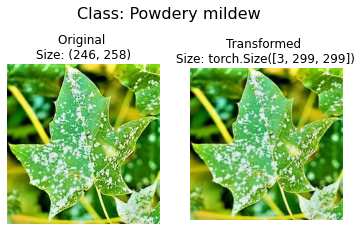

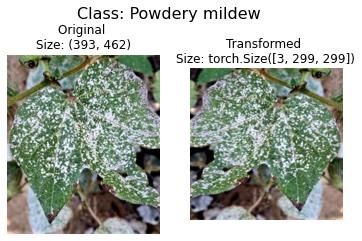

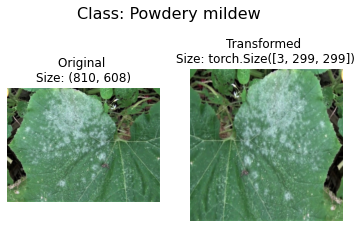

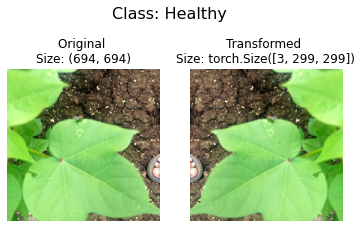

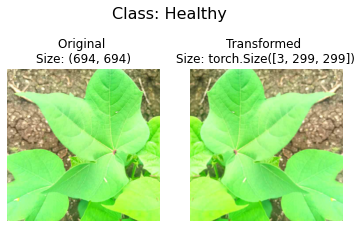

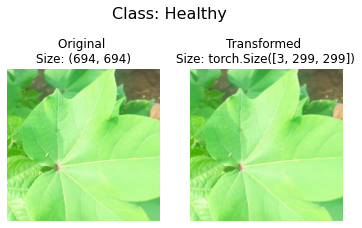

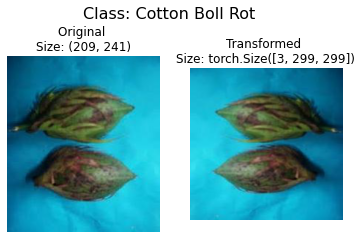

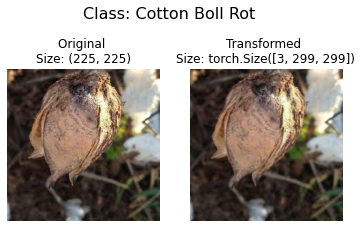

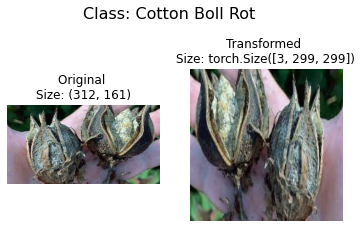

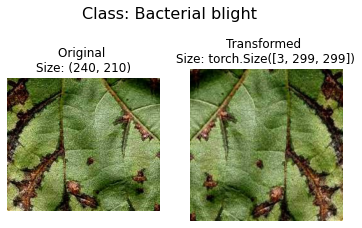

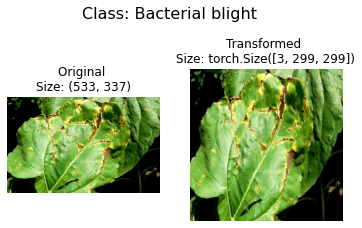

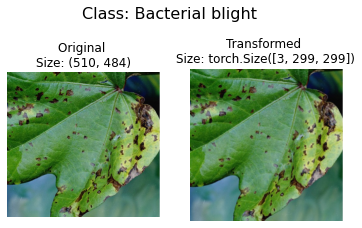

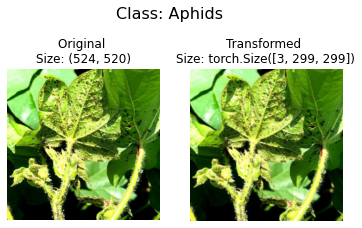

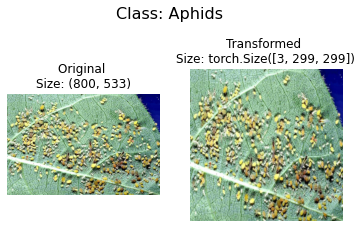

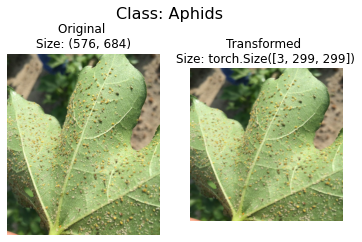

In [1]:
import time

# Record the start time
start_time = time.time()

import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as img:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(img)
            ax[0].set_title(f"Original \nSize: {img.size}")
            ax[0].axis("off")

            transformed_image = transform(img)
            ax[1].imshow(transformed_image.permute(1, 2, 0))
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            class_name = os.path.basename(os.path.dirname(image_path))
            fig.suptitle(f"Class: {class_name}", fontsize=16)

data_transform = transforms.Compose([
    transforms.Resize(size=(299, 299)),  # InceptionV3 requires input size to be (299, 299)
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

main_folder = "E:\\Cotton-Disease-Training\\trainning\\Cotton leaves - Training\\800 Images"

classes = ["Powdery mildew", "Healthy", "Cotton Boll Rot", "Bacterial blight", "Aphids"]
class_to_idx = {cls: i for i, cls in enumerate(classes)}

class_images = {cls: [] for cls in classes}

for cls in classes:
    class_folder = os.path.join(main_folder, cls)
    for filename in os.listdir(class_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(class_folder, filename)
            class_images[cls].append(img_path)

image_path_list = {cls: images for cls, images in class_images.items()}

for cls in classes:
    print(f"Plotting transformed images for class: {cls}")
    plot_transformed_images(image_path_list[cls], transform=data_transform, n=3)

train_data = datasets.ImageFolder(root=main_folder, transform=data_transform)
class_names = train_data.classes

train_dataloader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)

model = models.inception_v3(pretrained=True, aux_logits=True)

for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    corrects = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
            
        ##here
        # Inside the training loop
        with torch.set_grad_enabled(True):
            outputs, aux_outputs = model(inputs)  # InceptionV3 has auxiliary outputs
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Optionally, you can add the auxiliary loss to the total loss
            # The weight parameter can be adjusted based on your preference
            aux_loss = 0.4 * criterion(aux_outputs, labels)  # Adjust the weight as needed
            loss += aux_loss

            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_data)
    epoch_acc = corrects.double() / len(train_data)

    print(f'Epoch {epoch + 1}/{num_epochs} - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

# Save the fine-tuned model (with the weights that we want)
torch.save(model.state_dict(), "first_tuned_model_cotton_disease_inception.pth")


# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Execution time: {elapsed_time} seconds")